In [12]:
import os
import matplotlib.pyplot as plt
import torch
import torchvision
import numpy as np

In [32]:
# Set global variables

data_path = './datasets'
trainset_path = data_path + '/train'
testset_path = data_path + '/test'
valset_path = data_path + '/val'

classes = ['Normal', 'Pneumonia']

BATCH_SIZE = 4
NUM_WORKERS = 2

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

Number of images in ./datasets/train: 5216
Number of images in Normal class: 1341
Number of images in Pneumonia class: 3875


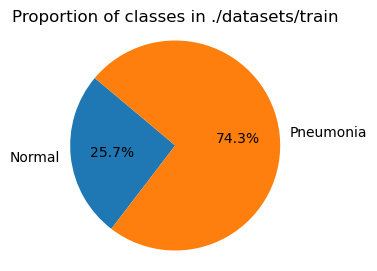

In [8]:
# View training dataset info

def viewDatasetInfo(path):
    normal = os.listdir(path + '/NORMAL')
    pneumonia = os.listdir(path + '/PNEUMONIA')
    quantities = [len(normal), len(pneumonia)]
    plt.figure(figsize=(4, 3))
    plt.pie(quantities, labels=classes, autopct='%1.1f%%', startangle=140)
    plt.title(f"Proportion of classes in {path}")
    plt.axis('equal')
    print(f"Number of images in {path}: {sum(quantities)}")
    print(f"Number of images in {classes[0]} class: {quantities[0]}")
    print(f"Number of images in {classes[1]} class: {quantities[1]}")
    plt.show()

viewDatasetInfo(trainset_path)

In [33]:
# Load datasets

trainset = torchvision.datasets.ImageFolder(root=trainset_path, transform=transform)
testset = torchvision.datasets.ImageFolder(root=testset_path, transform=transform)
valset = torchvision.datasets.ImageFolder(root=valset_path, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
valloder = torch.utils.data.DataLoader(valset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)


trainset_size = len(trainset)
testset_size = len(testset)
valset_size = len(valset)

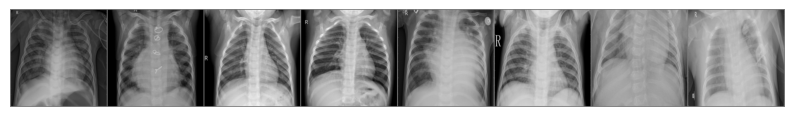

In [42]:
# View images from data

def show_batch(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

img_grid = torchvision.utils.make_grid(images)
show_batch(img_grid)